In [1]:
# Importing necessary libraries

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', False)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette("cubehelix") # Other palettes: "Set2", "husl", "cubehelix", "hls"

In [2]:
# Reading the input file

import os
cwd = os.getcwd()

train_values = cwd + "\\Source Data\\train_values.csv"
train_values = pd.read_csv(train_values)
train_labels = cwd + "\\Source Data\\train_labels.csv"
train_labels = pd.read_csv(train_labels)

test_values = cwd + "\\Source Data\\test_values.csv"
test_values = pd.read_csv(test_values)
test_id = test_values.patient_id
test = test_values.drop('patient_id', axis=1)

train = train_values.join(train_labels.set_index('patient_id'), on='patient_id', how='left')

In [3]:
# Data Prep

y = train['heart_disease_present']
x = train.drop(['heart_disease_present', 'patient_id'], axis=1)

In [4]:
x.dtypes

slope_of_peak_exercise_st_segment         int64
thal                                     object
resting_blood_pressure                    int64
chest_pain_type                           int64
num_major_vessels                         int64
fasting_blood_sugar_gt_120_mg_per_dl      int64
resting_ekg_results                       int64
serum_cholesterol_mg_per_dl               int64
oldpeak_eq_st_depression                float64
sex                                       int64
age                                       int64
max_heart_rate_achieved                   int64
exercise_induced_angina                   int64
dtype: object

In [5]:
# Select the columns to include

cols_to_include = list(x.columns)

cols_to_include = ['int64', 'float64']
x = x.select_dtypes(include=cols_to_include)
test = test.select_dtypes(include=cols_to_include)


In [6]:
# Generating dummies

x_rows = x.shape[0]
df = x.append(test)

df = pd.get_dummies(df, drop_first=True)

x = df.iloc[:x_rows,]
test = df.iloc[x_rows:,]


# Random Search Optimizer for Random Forest

In [27]:
# Creating a Random Grid

from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# model = (n_estimators=500, criterion='gini', max_depth=25, min_samples_leaf=5, oob_score=True, n_jobs=-1, random_state=10)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=50, stop=200, num=20)]

# Number of features to consider at every split (For max_features we can also consider sqrt or auto)
max_features = [int(x) for x in np.linspace(start= np.int(len(x.columns)/10),
                                            stop= np.int(len(x.columns)/2), num=6)]
# The split criterion
criterion = ['gini', 'entropy']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [4,5,6,7,10,13]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2,3,4,5,6,8]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Maximum number of levels in tree
max_features = [3,4,5,6,7,8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# random_grid

In [31]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [32]:
# Performing the Random Search

# Use the random grid to search for best hyperparameters
# Let us use the base model "model" that is already created to tune the model against
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, 
                                  param_distributions = random_grid, 
                                  n_iter = 100, cv = 3, scoring='neg_log_loss', verbose=100, random_state=42)
# Fit the random search model
model_random.fit(x, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] n_estimators=192, min_samples_split=5, min_samples_leaf=4, max_features=4, max_depth=13, criterion=gini, bootstrap=False 
[CV]  n_estimators=192, min_samples_split=5, min_samples_leaf=4, max_features=4, max_depth=13, criterion=gini, bootstrap=False, score=-0.4663277391778779, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] n_estimators=192, min_samples_split=5, min_samples_leaf=4, max_features=4, max_depth=13, criterion=gini, bootstrap=False 
[CV]  n_estimators=192, min_samples_split=5, min_samples_leaf=4, max_features=4, max_depth=13, criterion=gini, bootstrap=False, score=-0.389922904968671, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[CV] n_estimators=192, min_samples_split=5, min_samples_leaf=4, max_features=4, max_depth=13, criterion=g

[CV]  n_estimators=184, min_samples_split=6, min_samples_leaf=6, max_features=7, max_depth=6, criterion=entropy, bootstrap=False, score=-0.5257323821939708, total=   0.1s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    3.6s remaining:    0.0s
[CV] n_estimators=184, min_samples_split=6, min_samples_leaf=6, max_features=7, max_depth=6, criterion=entropy, bootstrap=False 
[CV]  n_estimators=184, min_samples_split=6, min_samples_leaf=6, max_features=7, max_depth=6, criterion=entropy, bootstrap=False, score=-0.41384269531460444, total=   0.2s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    3.9s remaining:    0.0s
[CV] n_estimators=184, min_samples_split=6, min_samples_leaf=6, max_features=7, max_depth=6, criterion=entropy, bootstrap=False 
[CV]  n_estimators=184, min_samples_split=6, min_samples_leaf=6, max_features=7, max_depth=6, criterion=entropy, bootstrap=False, score=-0.4083477697596853, total=   0.2s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.2s remaini

[CV]  n_estimators=57, min_samples_split=5, min_samples_leaf=4, max_features=6, max_depth=10, criterion=entropy, bootstrap=True, score=-0.4207451670557718, total=   0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    7.7s remaining:    0.0s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=3, max_depth=10, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=3, max_depth=10, criterion=entropy, bootstrap=True, score=-0.47774151277008226, total=   0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    7.7s remaining:    0.0s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=3, max_depth=10, criterion=entropy, bootstrap=True 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_features=3, max_depth=10, criterion=entropy, bootstrap=True, score=-0.37406412476789436, total=   0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    7.8s remaining: 

[CV]  n_estimators=89, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=11, criterion=entropy, bootstrap=False, score=-0.517552411331974, total=   0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:   11.5s remaining:    0.0s
[CV] n_estimators=89, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_estimators=89, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=11, criterion=entropy, bootstrap=False, score=-0.38759896716116876, total=   0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   11.6s remaining:    0.0s
[CV] n_estimators=89, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=11, criterion=entropy, bootstrap=False 
[CV]  n_estimators=89, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=11, criterion=entropy, bootstrap=False, score=-0.42376660922901804, total=   0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   11.8s remaini

[CV]  n_estimators=105, min_samples_split=13, min_samples_leaf=6, max_features=6, max_depth=5, criterion=gini, bootstrap=True, score=-0.40537482064079294, total=   0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   15.8s remaining:    0.0s
[CV] n_estimators=105, min_samples_split=13, min_samples_leaf=6, max_features=6, max_depth=5, criterion=gini, bootstrap=True 
[CV]  n_estimators=105, min_samples_split=13, min_samples_leaf=6, max_features=6, max_depth=5, criterion=gini, bootstrap=True, score=-0.43196340590572735, total=   0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   15.9s remaining:    0.0s
[CV] n_estimators=168, min_samples_split=4, min_samples_leaf=2, max_features=7, max_depth=13, criterion=gini, bootstrap=False 
[CV]  n_estimators=168, min_samples_split=4, min_samples_leaf=2, max_features=7, max_depth=13, criterion=gini, bootstrap=False, score=-0.49610200204121135, total=   0.2s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:   16.2s remaining:    0.0s

[CV]  n_estimators=97, min_samples_split=4, min_samples_leaf=2, max_features=4, max_depth=8, criterion=entropy, bootstrap=True, score=-0.38673247633729263, total=   0.1s
[CV] n_estimators=97, min_samples_split=4, min_samples_leaf=2, max_features=4, max_depth=8, criterion=entropy, bootstrap=True 
[CV]  n_estimators=97, min_samples_split=4, min_samples_leaf=2, max_features=4, max_depth=8, criterion=entropy, bootstrap=True, score=-0.4147984270427597, total=   0.1s
[CV] n_estimators=73, min_samples_split=10, min_samples_leaf=6, max_features=5, max_depth=10, criterion=entropy, bootstrap=True 
[CV]  n_estimators=73, min_samples_split=10, min_samples_leaf=6, max_features=5, max_depth=10, criterion=entropy, bootstrap=True, score=-0.4821642894384548, total=   0.0s
[CV] n_estimators=73, min_samples_split=10, min_samples_leaf=6, max_features=5, max_depth=10, criterion=entropy, bootstrap=True 
[CV]  n_estimators=73, min_samples_split=10, min_samples_leaf=6, max_features=5, max_depth=10, criterion=

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=6, max_features=7, max_depth=7, criterion=entropy, bootstrap=False, score=-0.40949895722614155, total=   0.4s
[CV] n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap=True 
[CV]  n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap=True, score=-0.486697296232171, total=   0.2s
[CV] n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap=True 
[CV]  n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap=True, score=-0.3782410997805445, total=   0.3s
[CV] n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap=True 
[CV]  n_estimators=144, min_samples_split=5, min_samples_leaf=3, max_features=3, max_depth=7, criterion=gini, bootstrap

[CV]  n_estimators=128, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=10, criterion=gini, bootstrap=False, score=-0.503978236878766, total=   0.2s
[CV] n_estimators=128, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=10, criterion=gini, bootstrap=False 
[CV]  n_estimators=128, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=10, criterion=gini, bootstrap=False, score=-0.38574692622865936, total=   0.2s
[CV] n_estimators=128, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=10, criterion=gini, bootstrap=False 
[CV]  n_estimators=128, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=10, criterion=gini, bootstrap=False, score=-0.4111019271476705, total=   0.1s
[CV] n_estimators=128, min_samples_split=10, min_samples_leaf=8, max_features=6, max_depth=9, criterion=gini, bootstrap=False 
[CV]  n_estimators=128, min_samples_split=10, min_samples_leaf=8, max_features=6, max_depth=9, criterion=gi

[CV]  n_estimators=89, min_samples_split=13, min_samples_leaf=4, max_features=6, max_depth=13, criterion=gini, bootstrap=True, score=-0.4271220663178177, total=   0.0s
[CV] n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstrap=False, score=-0.5175297650591949, total=   0.2s
[CV] n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstrap=False, score=-0.40641610119849275, total=   0.2s
[CV] n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=6, min_samples_leaf=8, max_features=8, max_depth=7, criterion=gini, bootstr

[CV]  n_estimators=192, min_samples_split=13, min_samples_leaf=8, max_features=3, max_depth=15, criterion=entropy, bootstrap=True, score=-0.4937790028554944, total=   0.1s
[CV] n_estimators=192, min_samples_split=13, min_samples_leaf=8, max_features=3, max_depth=15, criterion=entropy, bootstrap=True 
[CV]  n_estimators=192, min_samples_split=13, min_samples_leaf=8, max_features=3, max_depth=15, criterion=entropy, bootstrap=True, score=-0.4310489351599002, total=   0.2s
[CV] n_estimators=192, min_samples_split=13, min_samples_leaf=8, max_features=3, max_depth=15, criterion=entropy, bootstrap=True 
[CV]  n_estimators=192, min_samples_split=13, min_samples_leaf=8, max_features=3, max_depth=15, criterion=entropy, bootstrap=True, score=-0.4658573599009623, total=   0.1s
[CV] n_estimators=113, min_samples_split=5, min_samples_leaf=8, max_features=3, max_depth=7, criterion=gini, bootstrap=True 
[CV]  n_estimators=113, min_samples_split=5, min_samples_leaf=8, max_features=3, max_depth=7, crite

[CV]  n_estimators=81, min_samples_split=5, min_samples_leaf=2, max_features=5, max_depth=6, criterion=entropy, bootstrap=True, score=-0.39781189497005787, total=   0.0s
[CV] n_estimators=81, min_samples_split=5, min_samples_leaf=2, max_features=5, max_depth=6, criterion=entropy, bootstrap=True 
[CV]  n_estimators=81, min_samples_split=5, min_samples_leaf=2, max_features=5, max_depth=6, criterion=entropy, bootstrap=True, score=-0.4160860711625101, total=   0.0s
[CV] n_estimators=160, min_samples_split=10, min_samples_leaf=5, max_features=5, max_depth=15, criterion=gini, bootstrap=True 
[CV]  n_estimators=160, min_samples_split=10, min_samples_leaf=5, max_features=5, max_depth=15, criterion=gini, bootstrap=True, score=-0.4815362954608485, total=   0.1s
[CV] n_estimators=160, min_samples_split=10, min_samples_leaf=5, max_features=5, max_depth=15, criterion=gini, bootstrap=True 
[CV]  n_estimators=160, min_samples_split=10, min_samples_leaf=5, max_features=5, max_depth=15, criterion=gini,

[CV]  n_estimators=97, min_samples_split=7, min_samples_leaf=4, max_features=4, max_depth=8, criterion=gini, bootstrap=True, score=-0.42004430692655487, total=   0.0s
[CV] n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entropy, bootstrap=True 
[CV]  n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entropy, bootstrap=True, score=-0.4980605524478775, total=   0.2s
[CV] n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entropy, bootstrap=True 
[CV]  n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entropy, bootstrap=True, score=-0.4176346933736578, total=   0.2s
[CV] n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entropy, bootstrap=True 
[CV]  n_estimators=192, min_samples_split=6, min_samples_leaf=8, max_features=4, max_depth=9, criterion=entro

C:\Users\sivac\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'n_estimators': [50, 57, 65, 73, 81, 89, 97, 105, 113, 121, 128, 136, 144, 152, 160, 168, 176, 184, 192, 200], 'max_features': [3, 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15], 'min_samples_split': [4, 5, 6, 7, 10, 13], 'min_samples_leaf': [2, 3, 4, 5, 6, 8], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, ref

In [33]:
model_random.best_params_

{'n_estimators': 160,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 3,
 'max_depth': 9,
 'criterion': 'gini',
 'bootstrap': False}

In [38]:
# Performing the Train Test Split

from sklearn.model_selection import train_test_split
x_train, x_validation, y_train, y_validation = train_test_split(x,y, 
                                                                stratify=y, 
                                                                random_state=1, 
                                                                test_size=0.25)

Confustion Matrix for Training Data - Logistic Regression
[[75  0]
 [ 0 60]]
Confustion Matrix for Test Data - Logistic Regression
[[16  9]
 [ 3 17]]
Classification Report for Training Data - Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        75
           1       1.00      1.00      1.00        60

   micro avg       1.00      1.00      1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

Classification Report for Test Data - Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.64      0.73        25
           1       0.65      0.85      0.74        20

   micro avg       0.73      0.73      0.73        45
   macro avg       0.75      0.74      0.73        45
weighted avg       0.76      0.73      0.73        45

Log loss for Training data:  0.10221442676494231
Log loss for Validation dat

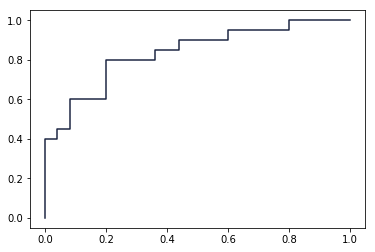

In [39]:
# Running the Random Forest Classifier using the best estimator

model = model_random.best_estimator_
model.fit(x_train, y_train)
train_predictions = model.predict(x_train)
predictions = model.predict(x_validation)

# Accuracy Metrics

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Confusion Matrix Comparison
print("Confustion Matrix for Training Data - Logistic Regression")
print(confusion_matrix(y_train, train_predictions))
print("Confustion Matrix for Test Data - Logistic Regression")
print(confusion_matrix(y_validation, predictions))

# Classification Report Comparison
print("Classification Report for Training Data - Logistic Regression")
print(classification_report(y_train, train_predictions))
print("Classification Report for Test Data - Logistic Regression")
print(classification_report(y_validation, predictions))

proba_train_predictions = model.predict_proba(x_train)[:,1]
proba_predictions = model.predict_proba(x_validation)[:,1]
roc_auc_score(y_validation, proba_predictions, average='weighted')

# Print the log loss metric

print("Log loss for Training data: ", log_loss(y_train, proba_train_predictions))
print("Log loss for Validation data: ", log_loss(y_validation, proba_predictions))

fpr, tpr, threshold = roc_curve(y_validation, proba_predictions)

# Calculating the AUC Score
auc = np.trapz(tpr,fpr)
pltTitle = print("\nAUROC Plot from Logistic Regression:", "%.4f" %auc)

# Plotting the ROC Curve
plt.plot(fpr,tpr)
plt.title(pltTitle)
plt.show()

In [40]:
# Generating output using Logistic Regression without normalizing the data

proba_test_predictions = model.predict_proba(test)[:,1]

output = pd.DataFrame({'patient_id': test_id, 'heart_disease_present':proba_test_predictions})
output.to_csv(cwd + "\\Output Data\\Submission 15 - RF with RandomSearch logloss 0.5117.csv", index=False)

In [35]:
# Pushing the repo to git

! cd "C:\\Users\\sivac\\Documents\\Python Projects\\Driven Data\\Predicting Heart Disease"

! git add .
! git commit -am "Submission 13 - Logistic Regression LB 0.397"
! git push

The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.


[master 8cf5979] Submission 13 - Logistic Regression LB 0.397
 6 files changed, 3036 insertions(+), 606 deletions(-)
 rewrite .ipynb_checkpoints/Data Prep and Base Model-checkpoint.ipynb (68%)
 create mode 100644 .ipynb_checkpoints/Submission 13 - Logistic Regression LB 0.397-checkpoint.ipynb
 rewrite Data Prep and Base Model.ipynb (67%)
 create mode 100644 Output Data/Submission 13 - Simple Logistic Regression logloss 0.5536.csv
 create mode 100644 Output Data/Submission 14 - Simple NB logloss 0.9905.csv
 create mode 100644 Submission 13 - Logistic Regression LB 0.397.ipynb


To https://github.com/sivacharansrc/Predicting-Heart-Disease.git
   0a1a28b..8cf5979  master -> master
